In [1]:
import numpy as np
import obspy
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import glob,os
#import STRAINPROC
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import random
from matplotlib.dates import date2num, num2date
from numba import jit
from math import ceil
import pickle
from scipy.stats import linregress

/tmp/ipykernel_1611949/1026219418.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
def sample_puller(data,window_length,creep_events_start,creep_events_end):
    '''data: time and slip
       window_length : days to calculate variance over
    '''
    index_ARRAY = np.arange(0,len(data[0]),1)
    test_list = []
    correct_length = False
    no_creep_event = False
    while correct_length==False & no_creep_event == False:
        #while no_creep_event == False:
        choice = np.random.choice(index_ARRAY)
        time_chosen = data[0][choice]
        boolarr = np.logical_and(data[0]>=time_chosen,data[0]<=time_chosen+window_length)
        window_slip = data[1][boolarr]
        window_time = data[0][boolarr]
        starts_ok = np.any((creep_events_start > window_time[0]) & (creep_events_start < window_time[-1]))
        ends_ok = np.any((creep_events_end > window_time[0]) & (creep_events_end < window_time[-1]))
        if starts_ok + ends_ok ==0:
            no_creep_event = True
        if len(window_time) == (24*6*window_length)+1:
            correct_length = True            
    return window_slip



def matrix_samples(data,window_length,creep_events_start,creep_events_end,N):
    matrix_data = np.zeros((N,24*6*window_length+1))
    print(matrix_data.shape)
    window_i = sample_puller(data,window_length,creep_events_start,creep_events_end)
    #print(window_i)
    for i in range(N):#len(window_i)):
        #print(i)
        window_j = sample_puller(data,window_length,creep_events_start,creep_events_end)
        window_j = window_j - window_j[0]
        #print(i)
        matrix_data[i] = window_j
    #print(matrix_data)
    #matrix_cov = np.cov(matrix_data)
    matrix_T = matrix_data.T
    return matrix_T

def sample_puller_wn(data,window_length):
    '''data: time and slip
       window_length : days to calculate variance over
    '''
    index_ARRAY = np.arange(0,len(data),1)
    test_list = []
    #print(len(data))
        #while no_creep_event == False:
    choice = np.random.choice(index_ARRAY)
    #print(choice)
    if choice >len(data) - window_length:
        choice_start = choice-window_length
        window_slip = data[choice_start:choice]
        #print(np.array(data)[choice_start:choice])
    else:
        choice_end = choice+window_length
        window_slip = data[choice:choice_end]
        #print(np.array(data)[choice:choice_end])
    return window_slip

def matrix_samples_wn(data,window_length,N):
    matrix_data = np.zeros((N,24*6*window_length+1))
    print(matrix_data.shape)
    window_i = sample_puller_wn(data,24*6*window_length+1)
    #print(window_i)
    for i in range(N):#len(window_i)):
        #print(i)
        window_j = sample_puller_wn(data,24*6*window_length+1)
        #print(window_j)
        window_j = np.array(window_j) - window_j[0]
        #print(i)
        matrix_data[i] = window_j
    #print(matrix_data)
    #matrix_cov = np.cov(matrix_data)
    matrix_T = matrix_data.T
    return matrix_T

@jit(nopython=True,error_model = 'numpy')
def covarience_cal(matrix_row_i,matrix_row_j):
    covarience = np.sum((matrix_row_i)*(matrix_row_j))/(len(matrix_row_i)-1)
    return covarience

@jit(nopython=True,error_model = 'numpy')
def covariance_matrix_maker(data_matrix):
    covariance_matrix = np.zeros((len(data_matrix),len(data_matrix)))
    for i in range(len(data_matrix)):
        for j in range(i,len(data_matrix)):
            cov_sel_rows = covarience_cal(data_matrix[i],data_matrix[j])
            covariance_matrix[i,j] = cov_sel_rows
            if i != j:
                covariance_matrix[j,i] = cov_sel_rows
    return covariance_matrix

#@jit(nopython=True,error_model = 'numpy')
def noise_adder(covariance_matrix,multiplier):
    rng = np.random.default_rng()
    noise_matrix = np.zeros((len(covariance_matrix),len(covariance_matrix)))
    for i in range(len(covariance_matrix)):
        for j in range(i,len(covariance_matrix)):
            rfloat = rng.random()
            #print(rfloat)
            random_noise = multiplier*covariance_matrix[1,1]
            #print(random_noise)
            #noise_matrix[i,j] = random_noise
            if i == j:
                noise_matrix[j,i] = random_noise
    return noise_matrix


In [22]:
vls = np.loadtxt("../../DATA_10MIN/RAW/San_Andreas/xhr2_10min.txt", dtype = str)
Year  = vls[:,0].astype(int)
Time  = vls[:,1].astype(float)
min10_creep_XHR_A  = vls[:,2].astype(float)
tm_XHR_A =np.array([dt.datetime(Year[k],1,1) + dt.timedelta(days = Time[k] -1) for k in range (0, len(Year))])
vls2 = np.loadtxt("../../DATA_10MIN/RAW/San_Andreas/xhr3_10min.txt", dtype = str)
Year2  = vls2[:,0].astype(int)
Time2  = vls2[:,1].astype(float)
min10_creep_XHR_B  = vls2[:,2].astype(float)
tm_XHR_B =np.array([dt.datetime(Year2[k],1,1) + dt.timedelta(days = Time2[k] -1) for k in range (0, len(Year2))])
#tm_XHR = np.append(tm_XHR,tm2_XHR)
#min10_creep_XHR=np.append(min10_creep_XHR,min10_creep2_XHR)
tm_XHR_A = pd.Series(tm_XHR_A)
tm_XHR_B = pd.Series(tm_XHR_B)

vls = np.loadtxt("../../DATA_10MIN/RAW/San_Andreas/cwn1_10min_1_2_21.txt", dtype = str)
Year  = vls[:,0].astype(int)
Time  = vls[:,1].astype(float)
min10_creep_CWN  = vls[:,2].astype(float)
tm_CWN =np.array([dt.datetime(Year[k],1,1) + dt.timedelta(days = Time[k] -1) for k in range (0, len(Year))])
tm_CWN = pd.Series(tm_CWN)

XHR = pd.read_csv('../..//CREEP_CATALOGUE/Auto/Hourly_Trough/Tidied/XHR_14_OCT_20.csv',index_col=0)
CWN = pd.read_csv('../../CREEP_CATALOGUE/Auto/Hourly_Trough/Tidied/CWN_14_OCT_20.csv',index_col=0)

xhr_dur = (pd.to_datetime(XHR['End_Time']) - pd.to_datetime(XHR['Start_Time']))/dt.timedelta(days=1)
XHR_max = ceil(np.max(xhr_dur))
XHR_median = ceil(np.median(xhr_dur))

cwn_dur = (pd.to_datetime(CWN['End_Time']) - pd.to_datetime(CWN['Start_Time']))/dt.timedelta(days=1)
CWN_max = ceil(np.max(cwn_dur))

for j in range(len(XHR)):
    boolarr_A = np.logical_or(tm_XHR_A<pd.to_datetime(XHR['Start_Time'].iloc[j]),tm_XHR_A>pd.to_datetime(XHR['End_Time'].iloc[j]))
    tm_XHR_A = tm_XHR_A[boolarr_A]
    min10_creep_XHR_A = min10_creep_XHR_A[boolarr_A]
    boolarr_B = np.logical_or(tm_XHR_B<pd.to_datetime(XHR['Start_Time'].iloc[j]),tm_XHR_B>pd.to_datetime(XHR['End_Time'].iloc[j]))
    tm_XHR_B = tm_XHR_B[boolarr_B]
    min10_creep_XHR_B = min10_creep_XHR_B[boolarr_B]

XHR_starts = date2num(XHR.Start_Time)
XHR_ends = date2num(XHR.End_Time)
tm_num_XHR_A = date2num(tm_XHR_A)
tm_num_XHR_B = date2num(tm_XHR_B)

CWN_starts = date2num(CWN.Start_Time)
CWN_ends = date2num(CWN.End_Time)
tm_num_CWN = date2num(tm_CWN)

In [217]:
min10_creep_XHR_B

array([ 11.79 ,  11.79 ,  11.79 , ..., 113.185, 113.198, 113.198])

507901

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


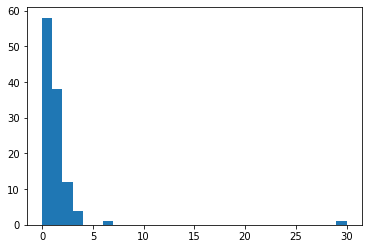

In [25]:
bins = np.linspace(0,30,31)
#print(bins)
plt.figure()
plt.hist(xhr_dur,bins=bins)
plt.show()

In [5]:
XHR_median

1

In [284]:
from random import gauss
from random import seed
# seed random number generator
seed(1)
# create white noise series
rng = np.random.default_rng()
white_noise = [covariance_matrix_XHR_A[1,1]*rng.random() for i in range(2900000)]
'''def matrix_select_random(n):
    wnm =  np.zeros((n,n))
    for i in range(n):
        #series = [gauss(0.0, 1.0) for i in range(n)]
        series = [rng.random() for i in range(n)]
        wnm[i] = series - np.mean(series)
    return wnm'''

'def matrix_select_random(n):\n    wnm =  np.zeros((n,n))\n    for i in range(n):\n        #series = [gauss(0.0, 1.0) for i in range(n)]\n        series = [rng.random() for i in range(n)]\n        wnm[i] = series - np.mean(series)\n    return wnm'

In [285]:
#wnm_test = matrix_select_random(100)
#wnm_test_cov = covariance_matrix_maker(wnm_test)
#wnm_test_cov[1,1]

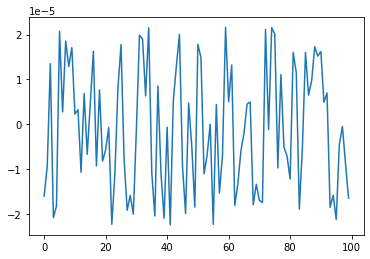

In [286]:
plt.figure()
plt.plot(np.array(white_noise)[0:100]-np.mean(white_noise))
plt.show()

In [287]:
#plt.figure()
#plt.imshow(wnm_test_cov)
#plt.colorbar()
#plt.show()

In [288]:
#matrix_XHR_A = matrix_samples([tm_num_XHR_A,min10_creep_XHR_A],4,XHR_starts,XHR_ends,50000)
#matrix_XHR_B = matrix_samples([tm_num_XHR_B,min10_creep_XHR_B],4,XHR_starts,XHR_ends,50000)
matrix_white_noise = matrix_samples_wn(white_noise,4,5000)
#matrix_CWN = matrix_samples([tm_num_CWN,min10_creep_CWN],ceil(1.25*CWN_max),CWN_starts,CWN_ends)

(5000, 577)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
27

1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183


3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825


In [289]:
np.save('../../Rheology/XHR/white_noise_matrix_4days_21_APR_23.npy',matrix_white_noise)
np.save('../../Rheology/XHR/XHR_2_matrix_4days_21_APR_23.npy',matrix_XHR_A)
np.save('../../Rheology/XHR/XHR_3_matrix_4days_21_APR_23.npy',matrix_XHR_B)


In [290]:
matrix_white_noise = np.load('../../Rheology/XHR/white_noise_matrix_4days_21_APR_23.npy')
matrix_XHR_A = np.load('../../Rheology/XHR/XHR_2_matrix_4days_21_APR_23.npy')
matrix_XHR_B = np.load('../../Rheology/XHR/XHR_3_matrix_4days_21_APR_23.npy')

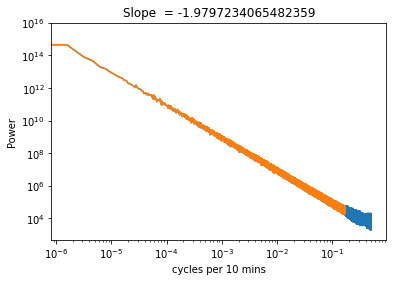

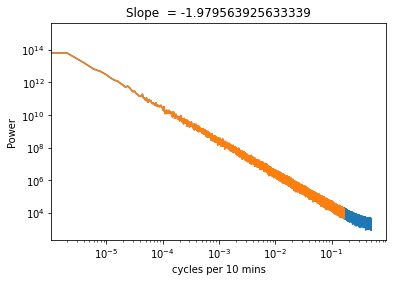

In [291]:
freq = np.fft.rfftfreq(min10_creep_XHR_A.size,d=1) #returns an array giving the frequencies of corresponding elements in the output
power = abs(np.fft.rfft(min10_creep_XHR_A))**2 #creates power spectrum
idx = np.argsort(freq) #returns indecies that would sort the array 

boolarr = freq<=1/6
freq2 = freq[idx][boolarr]
power2 = power[idx][boolarr]
slope, intercept, r_value, p_value, std_err = linregress(np.log(freq2[1:]), np.log(power2[1:]))
plt.figure()
plt.loglog(freq[idx], power[idx])
plt.loglog(freq2, power2)
plt.xlabel('cycles per 10 mins')
plt.ylabel('Power')
plt.title('Slope  = {k}'.format(k=slope))
plt.show()

freq_B = np.fft.rfftfreq(min10_creep_XHR_B.size,d=1) #returns an array giving the frequencies of corresponding elements in the output
power_B = abs(np.fft.rfft(min10_creep_XHR_B))**2 #creates power spectrum
idx_B = np.argsort(freq_B) #returns indecies that would sort the array 

boolarr_B = freq_B<=1/6
freq2_B = freq_B[idx_B][boolarr_B]
power2_B = power_B[idx_B][boolarr_B]
slope, intercept, r_value, p_value, std_err = linregress(np.log(freq2_B[1:]), np.log(power2_B[1:]))
plt.figure()
plt.loglog(freq_B[idx_B], power_B[idx_B])
plt.loglog(freq2_B, power2_B)
plt.xlabel('cycles per 10 mins')
plt.ylabel('Power')
plt.title('Slope  = {k}'.format(k=slope))
plt.show()

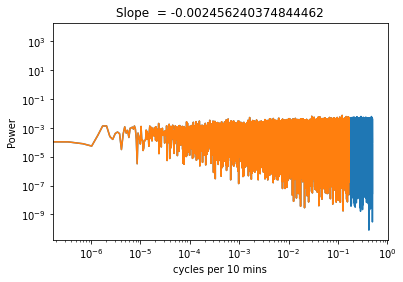

In [292]:
freq_B = np.fft.rfftfreq(np.array(white_noise).size,d=1) #returns an array giving the frequencies of corresponding elements in the output
power_B = abs(np.fft.rfft(np.array(white_noise)))**2 #creates power spectrum
idx_B = np.argsort(freq_B) #returns indecies that would sort the array 
boolarr_B = freq_B<=1/6
freq2_B = freq_B[idx_B][boolarr_B]
power2_B = power_B[idx_B][boolarr_B]
slope, intercept, r_value, p_value, std_err = linregress(np.log(freq2_B[1:]), np.log(power2_B[1:]))
plt.figure()
plt.loglog(freq_B[idx_B], power_B[idx_B])
plt.loglog(freq2_B, power2_B)
plt.xlabel('cycles per 10 mins')
plt.ylabel('Power')
plt.title('Slope  = {k}'.format(k=slope))
plt.show()

In [293]:
#covariance_matrix_XHR_A = covariance_matrix_maker(matrix_XHR_A)
#covariance_matrix_XHR_B = covariance_matrix_maker(matrix_XHR_B)
wnm_test_cov = covariance_matrix_maker(matrix_white_noise)
#covariance_matrix_CWN = covariance_matrix_maker(matrix_CWN)

In [294]:
wnm_test_cov.diagonal()

array([0.00000000e+00, 3.25628875e-10, 3.30812502e-10, 3.31367625e-10,
       3.28475627e-10, 3.33105467e-10, 3.25619461e-10, 3.35225905e-10,
       3.38485513e-10, 3.32797772e-10, 3.17614872e-10, 3.33277586e-10,
       3.33484365e-10, 3.35109486e-10, 3.29062694e-10, 3.33470436e-10,
       3.28264255e-10, 3.32629986e-10, 3.33988978e-10, 3.39727173e-10,
       3.32279227e-10, 3.32286253e-10, 3.34241475e-10, 3.19112198e-10,
       3.30967977e-10, 3.30701564e-10, 3.36903574e-10, 3.32574539e-10,
       3.30401393e-10, 3.31362349e-10, 3.26934058e-10, 3.25112206e-10,
       3.28818517e-10, 3.32080585e-10, 3.33178029e-10, 3.33146583e-10,
       3.25751863e-10, 3.27918868e-10, 3.29991522e-10, 3.40632725e-10,
       3.28834692e-10, 3.33943381e-10, 3.26795716e-10, 3.20270887e-10,
       3.37012905e-10, 3.26207785e-10, 3.30507551e-10, 3.23358125e-10,
       3.34930054e-10, 3.27111331e-10, 3.26801943e-10, 3.30613615e-10,
       3.40035630e-10, 3.26151141e-10, 3.25643444e-10, 3.30988552e-10,
      

In [295]:
from scipy.linalg import issymmetric
print(issymmetric(covariance_matrix_XHR_A))
print(issymmetric(covariance_matrix_XHR_B))
print(issymmetric(wnm_test_cov))

True
True
True


In [296]:
np.min(wnm_test_cov)

0.0

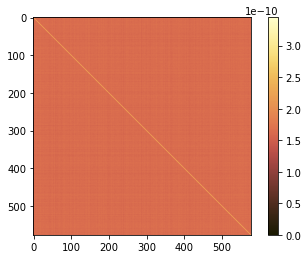

In [298]:
plt.figure()
plt.imshow(wnm_test_cov,cmap=cmc.lajolla_r)
plt.colorbar()
plt.show()

In [382]:
covariance_matrix_XHR_A_noise = covariance_matrix_XHR_A + noise_adder(covariance_matrix_XHR_A,0.1)
covariance_matrix_XHR_B_noise = covariance_matrix_XHR_B + noise_adder(covariance_matrix_XHR_B,0.1)
#covariance_matrix_CWN_noise = covariance_matrix_CWN + noise_adder(covariance_matrix_CWN)

In [383]:
matrix_samples_wn

<function __main__.matrix_samples_wn(data, window_length, N)>

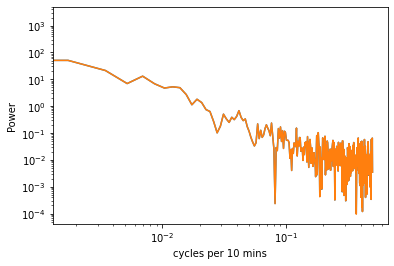

In [384]:
test_add_noise = matrix_XHR_A[:,0] + np.array(matrix_white_noise)[:,0]


freq = np.fft.rfftfreq(matrix_XHR_A[:,0].size,d=1) #returns an array giving the frequencies of corresponding elements in the output
power = abs(np.fft.rfft(matrix_XHR_A[:,0]))**2 #creates power spectrum
idx = np.argsort(freq) #returns indecies that would sort the array 

plt.figure()
plt.loglog(freq[idx], power[idx])
plt.xlabel('cycles per 10 mins')
plt.ylabel('Power')

freq_B = np.fft.rfftfreq(test_add_noise.size,d=1) #returns an array giving the frequencies of corresponding elements in the output
power_B = abs(np.fft.rfft(test_add_noise))**2 #creates power spectrum
idx_B = np.argsort(freq_B) #returns indecies that would sort the array 
plt.loglog(freq_B[idx_B], power_B[idx_B])
plt.show()

In [385]:
print(issymmetric(covariance_matrix_XHR_A_noise))
print(issymmetric(covariance_matrix_XHR_B_noise))
#print(issymmetric(covariance_matrix_CWN_noise))

True
True


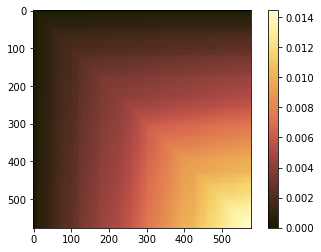

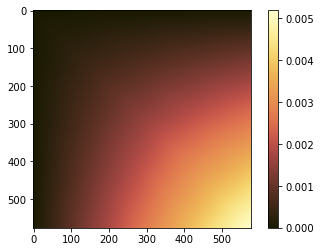

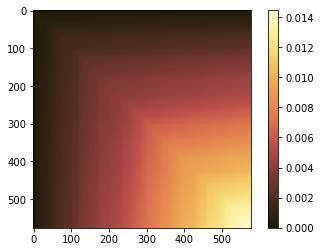

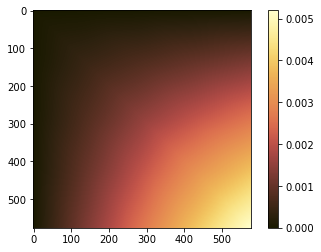

In [386]:
import cmcrameri.cm as cmc
plt.figure()
plt.imshow(covariance_matrix_XHR_A,cmap=cmc.lajolla_r)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(covariance_matrix_XHR_B,cmap=cmc.lajolla_r)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(covariance_matrix_XHR_A_noise,cmap=cmc.lajolla_r)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(covariance_matrix_XHR_B_noise,cmap=cmc.lajolla_r)
plt.colorbar()
plt.show()

In [387]:
XHR_A_eig_noise = np.linalg.eigvals(covariance_matrix_XHR_A_noise)
XHR_A_eig = np.linalg.eigvals(covariance_matrix_XHR_A)

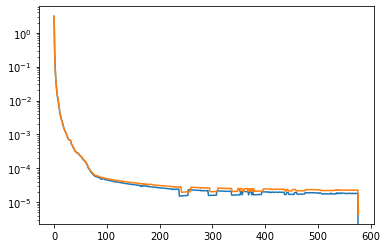

In [388]:
x_array = np.linspace(0,len(XHR_A_eig),len(XHR_A_eig))
plt.figure()
plt.plot(x_array,XHR_A_eig)
plt.plot(x_array,XHR_A_eig_noise)
plt.yscale('log')
plt.show()

In [389]:
print((XHR_A_eig))

[3.09423027e+00 2.78614327e-01 9.08627822e-02 4.65965331e-02
 2.97258360e-02 1.88870117e-02 1.40244365e-02 1.17658555e-02
 9.67376501e-03 6.81797275e-03 5.62934472e-03 4.07922430e-03
 3.68886288e-03 3.08175397e-03 2.68092705e-03 2.48285455e-03
 2.15103041e-03 1.88711769e-03 1.62299491e-03 1.40123329e-03
 1.35028313e-03 1.21847473e-03 1.14428920e-03 1.05600471e-03
 9.23420261e-04 8.48463355e-04 7.96586879e-04 7.15320669e-04
 6.95355958e-04 6.76426102e-04 6.68996494e-04 6.66479653e-04
 5.81345815e-04 5.07419560e-04 4.74075860e-04 4.56171053e-04
 4.11914265e-04 3.87169494e-04 3.82477097e-04 3.25158123e-04
 3.19248969e-04 3.08227363e-04 2.95661968e-04 2.83231082e-04
 2.85274206e-04 2.76690025e-04 2.68589470e-04 2.56225066e-04
 2.47149592e-04 2.32415916e-04 2.29104460e-04 2.19563367e-04
 2.08208156e-04 2.03453273e-04 1.88054815e-04 1.79825332e-04
 1.74971364e-04 1.69029845e-04 1.61285398e-04 1.52672459e-04
 1.50733688e-04 1.41191520e-04 1.26791008e-04 1.24127486e-04
 1.06404218e-04 9.950918

In [390]:
print((XHR_A_eig_noise))

[3.09423475e+00 2.78618804e-01 9.08672599e-02 4.66010107e-02
 2.97303137e-02 1.88914894e-02 1.40289142e-02 1.17703332e-02
 9.67824270e-03 6.82245044e-03 5.63382241e-03 4.08370199e-03
 3.69334057e-03 3.08623166e-03 2.68540473e-03 2.48733224e-03
 2.15550810e-03 1.89159538e-03 1.62747260e-03 1.40571098e-03
 1.35476082e-03 1.22295242e-03 1.14876688e-03 1.06048240e-03
 9.27897950e-04 8.52941044e-04 8.01064569e-04 7.19798358e-04
 6.99833647e-04 6.80903792e-04 6.73474183e-04 6.70957343e-04
 5.85823505e-04 5.11897250e-04 4.78553549e-04 4.60648742e-04
 4.16391954e-04 3.91647184e-04 3.86954786e-04 3.29635813e-04
 3.23726658e-04 3.12705052e-04 3.00139657e-04 2.87708771e-04
 2.89751895e-04 2.81167714e-04 2.73067160e-04 2.60702755e-04
 2.51627281e-04 2.36893606e-04 2.33582149e-04 2.24041056e-04
 2.12685845e-04 2.07930963e-04 1.92532504e-04 1.84303022e-04
 1.79449054e-04 1.73507535e-04 1.65763087e-04 1.57150148e-04
 1.55211378e-04 1.45669210e-04 1.31268697e-04 1.28605175e-04
 1.10881907e-04 1.039868

In [391]:
print((XHR_B_eig))

[3.09423027e+00 2.78614327e-01 9.08627822e-02 4.65965331e-02
 2.97258360e-02 1.88870117e-02 1.40244365e-02 1.17658555e-02
 9.67376501e-03 6.81797275e-03 5.62934472e-03 4.07922430e-03
 3.68886288e-03 3.08175397e-03 2.68092705e-03 2.48285455e-03
 2.15103041e-03 1.88711769e-03 1.62299491e-03 1.40123329e-03
 1.35028313e-03 1.21847473e-03 1.14428920e-03 1.05600471e-03
 9.23420261e-04 8.48463355e-04 7.96586879e-04 7.15320669e-04
 6.95355958e-04 6.76426102e-04 6.68996494e-04 6.66479653e-04
 5.81345815e-04 5.07419560e-04 4.74075860e-04 4.56171053e-04
 4.11914265e-04 3.87169494e-04 3.82477097e-04 3.25158123e-04
 3.19248969e-04 3.08227363e-04 2.95661968e-04 2.83231082e-04
 2.85274206e-04 2.76690025e-04 2.68589470e-04 2.56225066e-04
 2.47149592e-04 2.32415916e-04 2.29104460e-04 2.19563367e-04
 2.08208156e-04 2.03453273e-04 1.88054815e-04 1.79825332e-04
 1.74971364e-04 1.69029845e-04 1.61285398e-04 1.52672459e-04
 1.50733688e-04 1.41191520e-04 1.26791008e-04 1.24127486e-04
 1.06404218e-04 9.950918

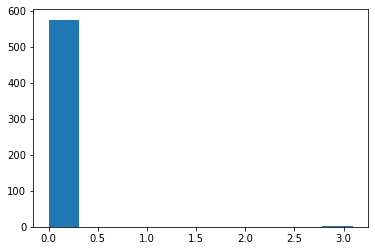

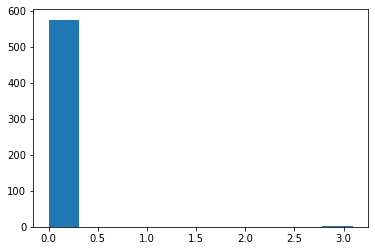

In [392]:
plt.figure()
plt.hist(XHR_A_eig)
plt.show()
plt.figure()
plt.hist(XHR_B_eig)
plt.show()

In [393]:
np.min(np.linalg.eigvals(covariance_matrix_XHR_A_noise))

4.477689553791339e-06

In [394]:
np.min(np.linalg.eigvals(covariance_matrix_XHR_B_noise))

4.880437608752229e-07

In [396]:
np.save('../../Rheology/XHR/XHR_2_covariance_matrix_4days_27_APR_23.npy',covariance_matrix_XHR_A_noise)
np.save('../../Rheology/XHR/XHR_3_covariance_matrix_4days_27_APR_23.npy',covariance_matrix_XHR_B_noise)
#np.save('../../Rheology/CWN/CWN_covariance_matrix_{k}days_21_APR_23.npy'.format(k=ceil(1.25*CWN_max)),covariance_matrix_CWN_noise)

In [329]:
'''with open ('../../Rheology/XHR/XHR_2_covariance_matrix_{k}_31_MAR_23.txt'.format(k=XHR_max),"wb") as f1:
    pickle.dump(covariance_matrix_XHR_A,f1)
    
with open ('../../Rheology/XHR/XHR_3_covariance_matrix_{k}_31_MAR_23.txt'.format(k=XHR_max),"wb") as f2:
    pickle.dump(covariance_matrix_XHR_B,f2)
    
with open ('../../Rheology/CWN/CWN_covariance_matrix_{k}_31_MAR_23.txt'.format(k=CWN_max),"wb") as f3:
    pickle.dump(covariance_matrix_CWN,f3)'''

'with open (\'../../Rheology/XHR/XHR_2_covariance_matrix_{k}_31_MAR_23.txt\'.format(k=XHR_max),"wb") as f1:\n    pickle.dump(covariance_matrix_XHR_A,f1)\n    \nwith open (\'../../Rheology/XHR/XHR_3_covariance_matrix_{k}_31_MAR_23.txt\'.format(k=XHR_max),"wb") as f2:\n    pickle.dump(covariance_matrix_XHR_B,f2)\n    \nwith open (\'../../Rheology/CWN/CWN_covariance_matrix_{k}_31_MAR_23.txt\'.format(k=CWN_max),"wb") as f3:\n    pickle.dump(covariance_matrix_CWN,f3)'

In [342]:
np.min((np.linalg.inv(covariance_matrix_XHR_A_noise)))

-5606.756849084495

In [16]:
ceil(CWN_max*1.25)

12

In [18]:
C_matrix_2 = np.load('../../Rheology/XHR/XHR_2_covariance_matrix_38days_18_APR_23.npy')

In [20]:
print(issymmetric(C_matrix_2))

True


In [39]:
cov_fixer_CWN = covariance_matrix_CWN[1,1]*np.identity(n=len(covariance_matrix_CWN))*10E

In [40]:
cov_test = cov_fixer_CWN + covariance_matrix_CWN

In [41]:
np.linalg.eigvals(cov_test)

array([1.09419281e+03, 9.87438468e+01, 2.72831736e+01, ...,
       9.59723380e-05, 9.59723380e-05, 9.59723380e-05])

In [44]:
covariance_matrix_CWN[2,2]/covariance_matrix_CWN[1,1]

1.2015494462732212

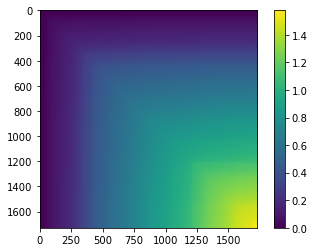

In [42]:
plt.figure()
plt.imshow(cov_test)
plt.colorbar()
plt.show()

In [45]:
# Test zone

In [46]:
Z = np.array([[0,0,0,0],[0,1,0,0],[0,1,1,0],[0,1,1,1]])
Z

array([[0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 1, 0],
       [0, 1, 1, 1]])

In [48]:
I = np.identity(4)
I

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [51]:
R = np.matmul(Z,np.matmul(I,Z.T))

In [52]:
R

array([[0., 0., 0., 0.],
       [0., 1., 1., 1.],
       [0., 1., 2., 2.],
       [0., 1., 2., 3.]])

In [55]:
H = np.array([[1,0,0,0],[1,1,0,0],[1,1,1,0],[1,1,1,1]])
E = np.matmul(H,H.T)
E

array([[1, 1, 1, 1],
       [1, 2, 2, 2],
       [1, 2, 3, 3],
       [1, 2, 3, 4]])

In [3]:
C_matrix_2 = np.load('../../Rheology/XHR/XHR_2_covariance_matrix_4days_27_APR_23.npy')
C_matrix_3 = np.load('../../Rheology/XHR/XHR_3_covariance_matrix_4days_27_APR_23.npy')

In [4]:
import cmcrameri.cm as cmc

In [5]:
%matplotlib qt
fig = plt.figure()
plt.subplot(1,2,1)
plt.imshow(C_matrix_2,cmap=cmc.devon,vmax=0.015)
#plt.colorbar(orientation='horizontal')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,2,2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.imshow(C_matrix_3,cmap=cmc.devon,vmax=0.015)
plt.colorbar(orientation='vertical')
plt.show()

In [6]:
plt.close('all')
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)
axes[1].tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)
axes[0].xaxis.set_label_position('top')
axes[1].xaxis.set_label_position('top')
for ax in axes.flat:
    im = ax.imshow(C_matrix_2,cmap=cmc.lipari, vmin=0, vmax=0.015)
    ax.set_xticks([0,144,288,432,576],[0,1,2,3,4])
    ax.set_yticks([0,144,288,432,576],[0,1,2,3,4])
axes[1].set_yticks([0,144,288,432,576],[])
axes[0].set_ylabel('Days')
axes[0].set_xlabel('Days')
axes[1].set_xlabel('Days')
axes[0].set_aspect('equal', 'box')
axes[1].set_aspect('equal', 'box')
ax1 = ax.imshow(C_matrix_3,cmap=cmc.lipari, vmin=0, vmax=0.015)
fig.colorbar(im, ax=axes.ravel().tolist(),orientation='horizontal',label='$mm^2$')
fig.text(0.05,0.92,'a): XHR2',fontsize=14,bbox=dict(facecolor='white', boxstyle='round',alpha=0.7))
fig.text(0.5,0.92,'b): XHR3',fontsize=14,bbox=dict(facecolor='white', boxstyle='round',alpha=0.7))
fig.subplots_adjust(left=0.125, bottom=0.360, right=0.90, top=0.870, wspace=0.2, hspace=0.2)
fig.set_size_inches(6,4)
plt.show()

In [19]:
C_matrix_2.shape

(577, 577)

In [53]:
plt.close('all')

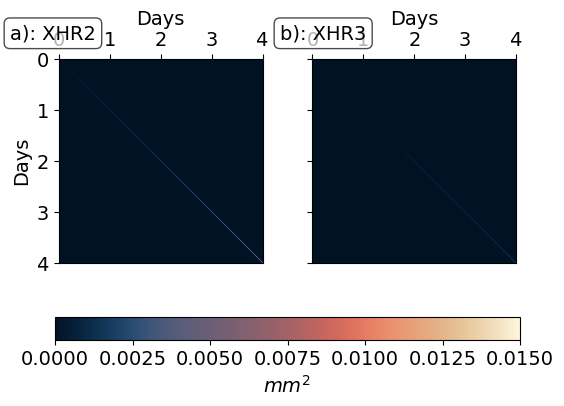

In [7]:
plt.close('all')
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)
axes[1].tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)
axes[0].xaxis.set_label_position('top')
axes[1].xaxis.set_label_position('top')
for ax in axes.flat:
    im = ax.imshow(np.diag(np.diag(C_matrix_2)),cmap=cmc.lipari, vmin=0, vmax=0.015)
    ax.set_xticks([0,144,288,432,576],[0,1,2,3,4])
    ax.set_yticks([0,144,288,432,576],[0,1,2,3,4])
axes[1].set_yticks([0,144,288,432,576],[])
axes[0].set_ylabel('Days')
axes[0].set_xlabel('Days')
axes[1].set_xlabel('Days')
axes[0].set_aspect('equal', 'box')
axes[1].set_aspect('equal', 'box')
ax1 = ax.imshow(np.diag(np.diag(C_matrix_3)),cmap=cmc.lipari, vmin=0, vmax=0.015)
fig.colorbar(im, ax=axes.ravel().tolist(),orientation='horizontal',label='$mm^2$')
fig.text(0.05,0.92,'a): XHR2',fontsize=14,bbox=dict(facecolor='white', boxstyle='round',alpha=0.7))
fig.text(0.5,0.92,'b): XHR3',fontsize=14,bbox=dict(facecolor='white', boxstyle='round',alpha=0.7))
fig.subplots_adjust(left=0.125, bottom=0.360, right=0.90, top=0.870, wspace=0.2, hspace=0.2)
fig.set_size_inches(6,4)
plt.show()

In [54]:
plt.figure()
ax = plt.subplot(1,1,1)
plt.plot(np.diag(C_matrix_2))
plt.plot(np.diag(C_matrix_3))
plt.ylabel('Variance')
ax.set_xticks([0,144,288,432,576],[0,1,2,3,4])
plt.xlabel("Days")
plt.show()